In [8]:
# %pip install ipynb

In [9]:
# import notebook
from ipynb.fs.full.facial_similarity_checker import *

# import the necessary packages
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

In [10]:
# helper function 
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [19]:
def align_images(image, template, maxFeatures=500, keepPercent=0.2,
    debug=False):
    # convert both the input image and template to grayscale
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # use ORB to detect keypoints and extract (binary) local
    # invariant features
    orb = cv2.ORB_create(maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)
    
    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)

    # sort the matches by their distance (the smaller the distance,
    # the "more similar" the features are)
    matches = sorted(matches, key=lambda x:x.distance)
    # keep only the top matches
    keep = int(len(matches) * keepPercent)
    matches = matches[:keep]
    
    # check to see if we should visualize the matched keypoints
    if debug:
        matchedVis = cv2.drawMatches(image, kpsA, template, kpsB,
            matches, None)
        matchedVis = imutils.resize(matchedVis, width=1000)
        plt_imshow("Matched Keypoints", matchedVis)
    
    # allocate memory for the keypoints (x, y)-coordinates from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    # loop over the top matches
    for (i, m) in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt
    print(f"ptsA: {ptsA}")
    print(f"ptsB: {ptsB}")

    # compute the homography matrix between the two sets of matched
    # points
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=5.0)
    print(f"H: {H}")
    
    # use the homography matrix to align the images
    (h, w) = template.shape[:2]
    aligned = cv2.warpPerspective(image, H, (w, h))
    
    # return the aligned image
    return aligned

x: 384	y: 672	Size: (765,765)
x: 325	y: 513	Size: (860,860)
{'verified': True, 'distance': 0.21522130178050536, 'threshold': 0.68, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 384, 'y': 672, 'w': 765, 'h': 765, 'left_eye': (770, 1273), 'right_eye': (627, 978)}, 'img2': {'x': 325, 'y': 513, 'w': 860, 'h': 860, 'left_eye': (890, 845), 'right_eye': (758, 1184)}}, 'time': 0.7}
The similarity between the images is:  0.21522130178050536
The images are the same person:  True


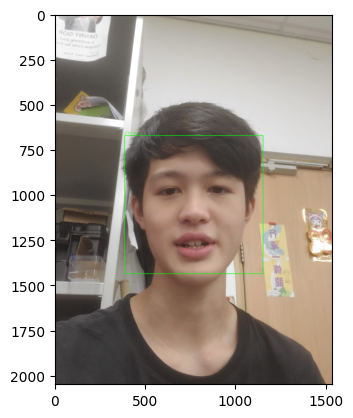

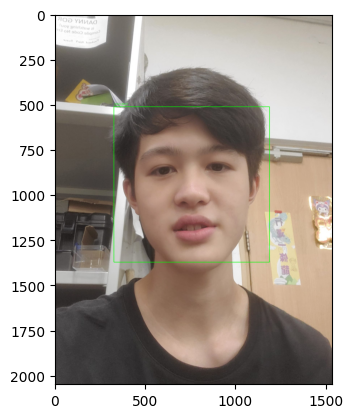

[INFO] loading images...
[INFO] aligning images...


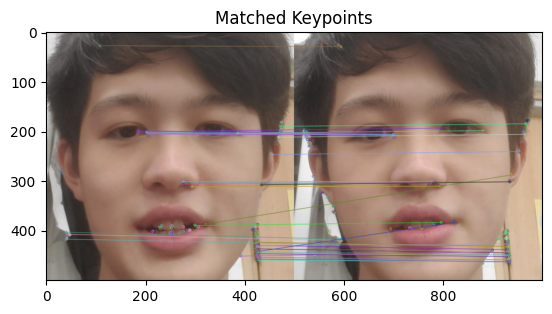

ptsA: [[609.63848877 431.30886841]
 [259.78067017 280.68255615]
 [288.23043823 288.23043823]
 [286.15686035 286.15686035]
 [415.05187988 435.95379639]
 [257.98910522 283.07138062]
 [288.57601929 288.57601929]
 [382.20605469 429.98181152]
 [596.16003418 612.        ]
 [289.20001221 289.20001221]
 [596.40002441 612.        ]
 [609.98406982 430.27203369]
 [283.07138062 283.07138062]
 [595.20001221 602.40002441]
 [600.4800415  643.68005371]
 [ 60.00000381 571.20001221]
 [540.46325684 286.65454102]
 [594.         594.        ]
 [597.60003662 624.        ]
 [394.1499939  426.39865112]
 [656.         298.        ]
 [594.72003174 593.2800293 ]
 [547.77606201 632.44805908]
 [412.06591797 437.14819336]
 [597.60003662 624.96002197]
 [599.04003906 636.4800415 ]
 [596.16003418 603.07208252]
 [386.98364258 422.81546021]
 [ 56.40000153 565.20001221]
 [601.20001221 640.80004883]
 [597.88806152 625.53607178]
 [418.03787231 280.68255615]
 [638.40002441 346.80001831]
 [600.         636.        ]
 [ 57.60

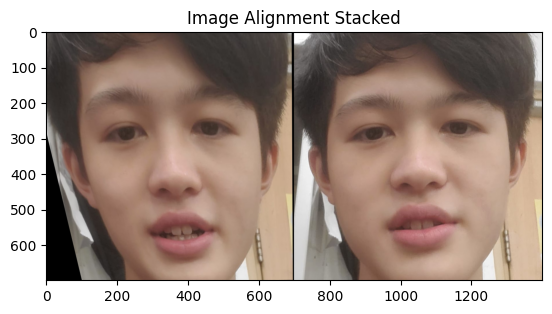

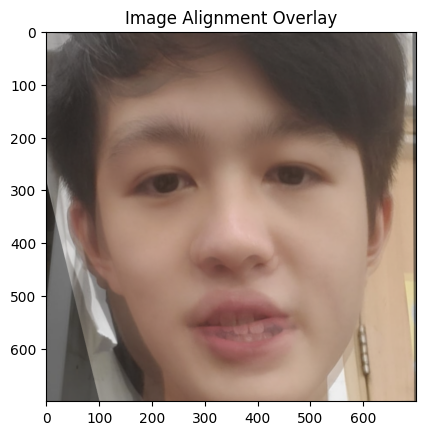

In [20]:
# construct the argument parser and parse the arguments
image1_path = "img/me_without_mask3.jpg"
image2_path = "img/me_without_mask4.jpg"

checker = facial_similarity_checker()
checker.load_image(image1_path, image2_path)
checker.show_result(True)

area1, area2 = checker.get_facial_area()

# load the input image and template from disk
print("[INFO] loading images...")
image = cv2.imread(image1_path)
template = cv2.imread(image2_path)

image = image[area1.y:area1.y+area1.height, area1.x:area1.x+area1.width]
template = template[area2.y:area2.y+area2.height, area2.x:area2.x+area2.width]

# resize both the aligned and template images so we can easily
# visualize them on our screen
image = imutils.resize(image, width=700, height=700)
template = imutils.resize(template, width=700, height=700)

# align the images
print("[INFO] aligning images...")
aligned = align_images(image, template, debug=True)

# our first output visualization of the image alignment will be a
# side-by-side comparison of the output aligned image and the
# template
stacked = np.hstack([aligned, template])

# our second image alignment visualization will be *overlaying* the
# aligned image on the template, that way we can obtain an idea of
# how good our image alignment is
overlay = template.copy()
output = aligned.copy()
cv2.addWeighted(overlay, 0.5, output, 0.5, 0, output)

# show the two output image alignment visualizations
plt_imshow("Image Alignment Stacked", stacked)
plt.show()

plt_imshow("Image Alignment Overlay", output)
plt.show()